In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

In [2]:
train = pd.read_csv('training.csv')
test = pd.read_csv('test_features.csv')

In [3]:
train.shape

(1000000, 10)

In [4]:
clean_df = train[train.salary > 0]
clean_df = clean_df.drop('jobId', axis = 1)
clean_df.shape

(999995, 9)

Building Data Frames for the models

In [5]:
feature_df = clean_df.drop('salary',axis = 1)
target = clean_df['salary']
job_id = test['jobId']
test = test.drop('jobId', axis = 1)

#### Building a ColumnTransformer
One Hot Encoding the categorical variables and passing the numerical values through. I am going to also build a dataframe just to show how many features we will have after one hot encoding

In [6]:
transformer = make_column_transformer(
(OneHotEncoder(), ['companyId','jobType',
            'degree','major','industry']),
            remainder = 'passthrough')

In [7]:
dummies = pd.get_dummies(feature_df, columns = ['companyId','jobType','degree','major','industry'])
dum = dummies.loc[:, ~dummies.columns.str.match('Unnamed')]
print(F"There are {len(dum.columns)} features after one hot encoding.")

There are 94 features after one hot encoding.


#### Baseline Model

In [8]:
avg = np.mean(target)
print(F"The average salary is ${avg:.2f}k")
print()
constant = [50,100,int(avg),150,200]
for con in constant:
    lst = [con]*len(target)
    mae = mean_absolute_error(target, lst)
    print(F"The MAE predicting only ${con}k is {mae:.5f}")

The average salary is $116.06k

The MAE predicting only $50k is 66.61364
The MAE predicting only $100k is 32.91118
The MAE predicting only $116k is 31.00767
The MAE predicting only $150k is 43.14076
The MAE predicting only $200k is 84.69683


The baseline models are calculating the mean absolute error between the target salaries and a constant value (50k, 100k, average, 150k & 200k). The best baseline model is to use the average salary of the target. The MAE is 31, meaning that a predicted salary of 116k is off by 31k. Not very good if we are to use this to bring in employees. Time to build some models to reduce the MAE and start hiring people!

### Linear Regression

In [9]:
model_lr = make_pipeline(transformer, LinearRegression())
mae_lr = cross_val_score(model_lr, feature_df, target, cv = 10, n_jobs = -1, scoring='neg_mean_absolute_error')
mean_mae_lr = -1 * np.mean(mae_lr)
cv_std_lr = np.std(mae_lr)
print(F"The 10-fold validation average MAE is {mean_mae_lr:.5f}, and the standard deviation is {cv_std_lr:.5f}")

The 10-fold validation average MAE is 15.84617, and the standard deviation is 0.04765


### How well does linear regression predict for a certain number of features? 
Well lets check that out! I will use Select K Best features with f regression to determine the best k features.

In [10]:
mae_feat = []
num_feat = []
for k in range(1,len(dum.columns)+1):
    model = make_pipeline(transformer, SelectKBest(f_regression, k = k), LinearRegression())
    mae = cross_val_score(model, feature_df, target, cv = 5, n_jobs = -1, scoring='neg_mean_absolute_error')
    mean_mae = -1 * np.mean(mae)
    cv_std = np.std(mae)
    mae_feat.append(mean_mae)
    num_feat.append(k)

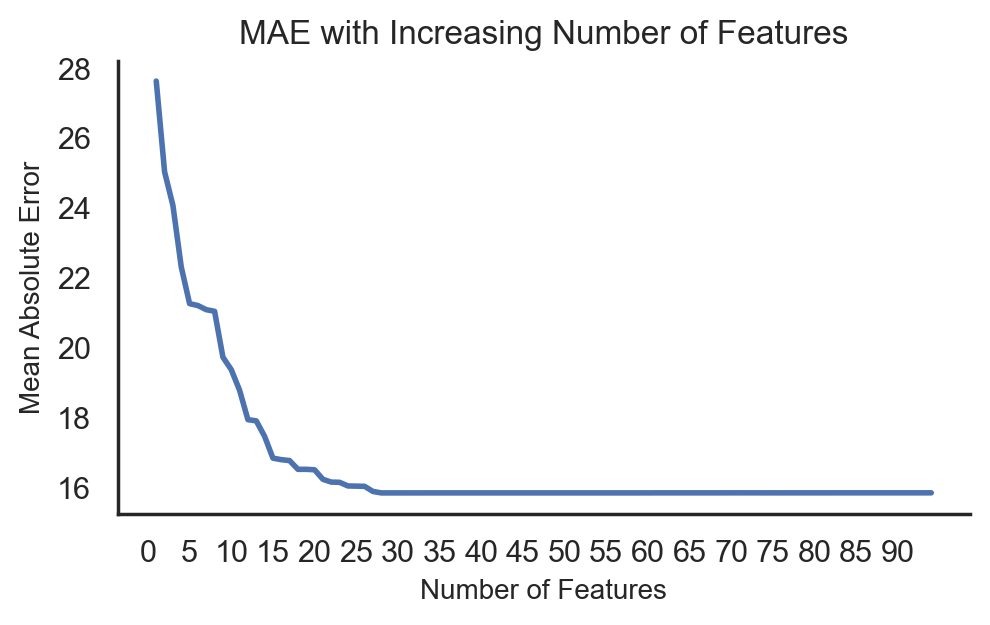

In [23]:
plt.rcParams['figure.dpi'] = 200
sns.set(style = "white")
fig, ax = plt.subplots(figsize = (7,3))
plt.plot(num_feat, mae_feat, linewidth = 2)
plt.xlabel('Number of Features', fontsize = 10)
plt.xticks(np.arange(0, max(num_feat), 5))
plt.ylabel('Mean Absolute Error', fontsize = 10)
plt.title('MAE with Increasing Number of Features', fontsize = 12)
sns.despine()
fig.set_size_inches(5.5,3)
plt.savefig('LinearNumFeatures.png', bbox_inches='tight');

We can see that after the 30 best predicting features the reduction in MAE is minute. This means that we can use the top 30 features to reduce model complexity and still have a model that is as good as a model with all the features.

In [24]:
data = {'Num_feat':num_feat,
        'Mae': mae_feat,}
lin_mae = pd.DataFrame(data)
lin_mae.loc[(lin_mae['Num_feat'] > 25) & (lin_mae['Num_feat'] < 35)]

,Num_feat,Mae
25,26,16.033172
26,27,15.886813
27,28,15.844379
28,29,15.844379
29,30,15.844379
30,31,15.844366
31,32,15.844436
32,33,15.844468
33,34,15.844763


As we can see, once we get to the top 28 features MAE stays at 15.844xx. Again, meaning that using the top 28 features will predict just as well as using all the features.

### Lasso Regression

In [19]:
lasso_pipe = make_pipeline(transformer, Lasso())
lasso = cross_val_score(lasso_pipe, feature_df, target, cv = 10, n_jobs = -1, scoring = 'neg_mean_absolute_error')
mae = -1 * np.mean(lasso)
std = np.std(lasso)
print(F"The 10-fold validation average MAE is {mae:.5f}, and the standard deviation is {std:.5f}")

The 10-fold validation average MAE is 17.88553, and the standard deviation is 0.05457


In [25]:
alpha = []
mae = []
for i in tqdm(range(1,100)):
    alpha.append(i/100)
    pipe = make_pipeline(transformer, Lasso(alpha = i/100))
    mae.append(-1*np.mean(cross_val_score(pipe, feature_df, target, 
        cv = 5, n_jobs = -1,scoring = 'neg_mean_absolute_error')))

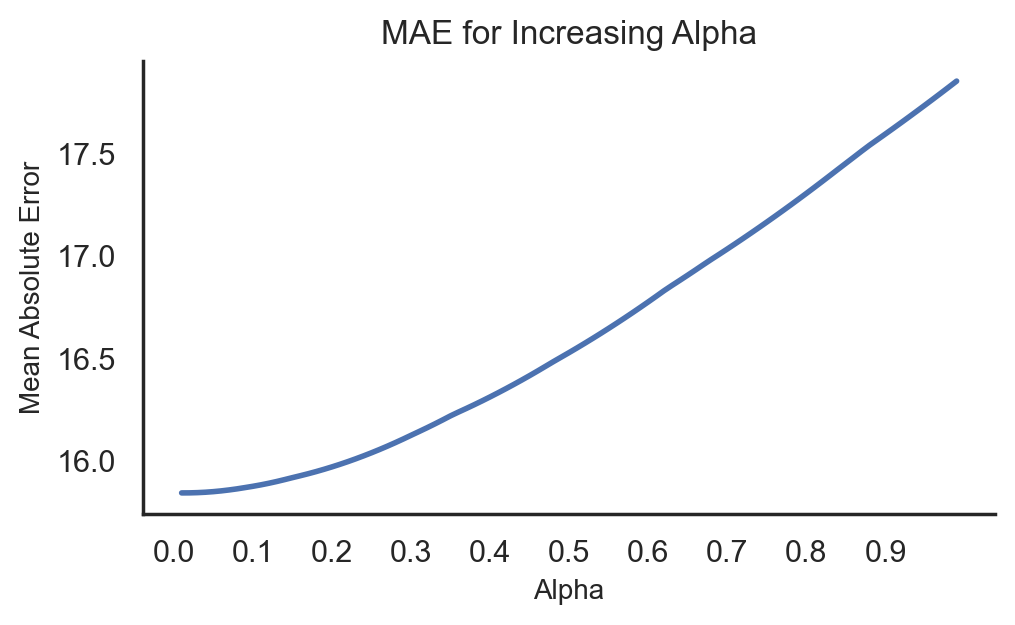

In [32]:
plt.rcParams['figure.dpi'] = 200
sns.set(style = "white")
fig, ax = plt.subplots(figsize = (7,3))
plt.plot(alpha, mae, linewidth = 2)
plt.xlabel('Alpha', fontsize = 10)
plt.xticks(np.arange(0, max(alpha), .1))
plt.ylabel('Mean Absolute Error', fontsize = 10)
plt.title('MAE for Increasing Alpha', fontsize = 12)
sns.despine()
fig.set_size_inches(5.5,3)
plt.savefig('LassoMAE.png', bbox_inches='tight');

In [33]:
lass = {'Alpha':alpha,
        'Mae': mae,}
lass_mae = pd.DataFrame(lass)
lass_mae.loc[(lass_mae['Alpha'] <.1)]

,Alpha,Mae
0,0.01,15.843854
1,0.02,15.844082
2,0.03,15.845187
3,0.04,15.847159
4,0.05,15.849996
5,0.06,15.853722
6,0.07,15.858331
7,0.08,15.863624
8,0.09,15.869791


The lasso regression is better than linear regression. Albeit, only by .001. 

What this means is that the two models estimates the salaries ~$15k. 

### Gradient Boosting

In [8]:
gbr = make_pipeline(transformer, GradientBoostingRegressor())
mae_gbr = cross_val_score(gbr, feature_df, target, cv = 5, n_jobs = -1, scoring = 'neg_mean_absolute_error')
mean_mae_gbr = -1 * np.mean(mae_gbr)
cv_std_gbr = np.std(mae_gbr)
print(F"The 5-fold validation average MAE is {mean_mae_gbr:.5f}, and the standard deviation is {cv_std_gbr:.5f}")

The 5-fold validation average MAE is 15.65603, and the standard deviation is 0.03836


### XGBoost

In [10]:
xgboost = make_pipeline(transformer, XGBRegressor())
mea_xgb = cross_val_score(xgboost, feature_df, target, cv = 5, n_jobs = -1, scoring = 'neg_mean_absolute_error')
mean_mea_xgb = -1 * np.mean(mea_xgb)
cv_std_xgb = np.std(mea_xgb)
print(F"The 5-fold validation average MAE is {mean_mea_xgb:.5f} with a standard deviation of {cv_std_xgb:.5f}")

The 5-fold validation average MAE is 15.65527 with a standard deviation of 0.03552


Now what is the best MAE that we can get using XGBoost? I'll do two approaches.

First will be to grid search over a large range of estimators, plot the results and find the inflection point. The inflection point will be where the reduction in MAE is negligible and tell use the number of estimators used.

The second approach I will use will be early stopping. Early stopping is when the model stops running if after increasing the number of estimators by a certain amount does not reduce the MAE by a set tolerance level. This also reduces the model complexity by finding the inflextion point with early stopping.

In [7]:
n_estimators = range(1,1001,25)
xgb_pipe = make_pipeline(transformer, XGBRegressor())
param_grid = {
    'xgbregressor__n_estimators': n_estimators,  
}
xgb_model = GridSearchCV(xgb_pipe, param_grid, cv = 2, n_jobs = -1,
                         scoring = 'neg_mean_absolute_error', return_train_score = True)
xgb_model.fit(feature_df, target)
print(F"Best MAE is: {(xgb_model.best_score_)*-1} with {xgb_model.best_params_}")
means = (xgb_model.cv_results_['mean_test_score'])*-1
stds = xgb_model.cv_results_['std_test_score']
params = xgb_model.cv_results_['params']


[03:29:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best MAE is: 15.358825293982076 with {'xgbregressor__n_estimators': 301}


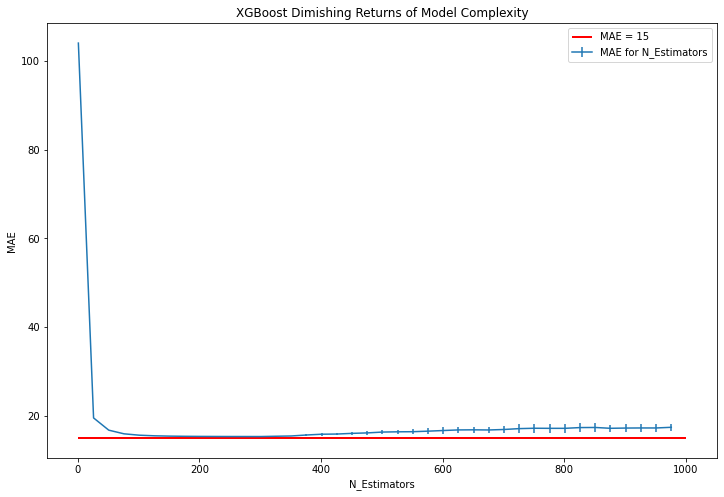

In [12]:
plt.figure(figsize=(12,8))
plt.hlines(y=15, xmin=0, xmax=1001, linewidth=2, color='r',label='MAE = 15')
plt.errorbar(n_estimators, means, yerr=stds, label = 'MAE for N_Estimators')
plt.title("XGBoost Dimishing Returns of Model Complexity")
plt.xlabel('N_Estimators')
plt.ylabel('MAE')
plt.legend()
plt.savefig('n_estimators.png')

In [11]:
xgb_data = {'N_estimators':n_estimators,
            'MAE':means}
xgb_df = pd.DataFrame(xgb_data)
xgb_df

,N_estimators,MAE
0,1,104.005785
1,26,19.551188
2,51,16.792710
3,76,15.971067
4,101,15.662226
5,126,15.523389
6,151,15.451587
7,176,15.410970
8,201,15.387530
9,226,15.374442


In [11]:
X_train, X_val, y_train, y_val = train_test_split(feature_df, target, test_size = 0.3)

In [ ]:
xgb_model = xgb.XGBRegressor(n_estimators = 1000)

fit_params={'early_stopping_rounds': 30, 
            'eval_metric': 'mae',
            'eval_set': [[val_x, val_y]]}

xgb = cross_val_score(xgb_model, train_x, train_y, cv = 5, scoring = 'neg_mean_absolute_error', fit_params = fit_params)
mae_xgb = -1 * np.mean(xgb)
cv_xgb = np.std(xgb)